# Twitter Sentiment Analysis coding task for Moberries

#### Part 2 of the coding task.

### Task 1: Analysis

In [1]:
# import first basic libraries
import pandas as pd
import csv
from bs4 import BeautifulSoup
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

The csv file is not well structured, so pd.read_csv() does not work very as I want. So I had to open the csv file and take the obseravation's format, as I want, row by row. Save the new file as a csv file under the name "clean.csv"

In [ ]:
# load csv file and save it, with a better strusture, as csv file again

if __name__ == "__main__":
    file_in = open("Sentiment_Analysis_Dataset.csv", "r")
    file_out = open("clean.csv", "w")
    writer = csv.writer(file_out)
    try:
        # we know the first 3 columns are consistent...
        for row in file_in:
            parts = row.strip().split(",")
            out = parts[0:3] + [",".join(parts[3:])]
            writer.writerow(out)
    finally:
        file_in.close()
        file_out.close()

In [3]:
# load the csv file
df = pd.read_csv('clean.csv')

Here I am spliting the new csv file into two dataasets, train(90%) and test(10%). Train is for my training process and therefore it will be splited again to train/validate set. Test set is the "unseen" one!

*--> I'm going straigth to "LOAD train dataset" because some cells bellow had been ran in another kenrel.*

In [ ]:
# following the suggestion for keeping 0.1 of data for test
test_df = df.sample(frac=0.1, replace=True)

# drop index of "test_df" from "df"
df = df.drop(test_df.index).reset_index(drop = True)

# reset index in test_df
test_df = test_df.reset_index(drop = True)


In [ ]:
# Drop 'ITEMID' column
df = df.drop('ItemID', axis = 1)
test_df = test_df.drop('ItemID', axis =1)

In [ ]:
# Change Column Names
df.columns = ['sentiment', 'source', 'text']
test_df.columns = df.columns

I did chose to save the new dataframes as "train.csv" and "test.csv" to make it sure, that when it comes to text cleaning pipeline, I always got same rows and content in my train dataset! (in case I have to restart my kernel)

In [ ]:
# SAVE dataframes 
df.to_csv('train.csv', encoding = 'utf-8')
test_df.to_csv('test.csv', encoding = 'utf-8')

In [4]:
# LOAD train dataset
df = pd.read_csv('train.csv')

# drop 2 more columns
# source column has info about the source of tweets: Sentiment140 and Kaggle. 
df = df.drop(['Unnamed: 0', 'source'], axis =1)


In [ ]:
df.shape

**As we finaly have the train dataset I'm going to search for usefull insights!**

...some rows first...

In [5]:
df.head()

,sentiment,text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,or i just worry too much?


In [6]:
df.tail()

,sentiment,text
1428426,1,Zzzzzz.... Finally! Night tweeters!
1428427,1,"""Zzzzzzz, sleep well people """
1428428,0,ZzzZzZzzzZ... wait no I have homework.
1428429,0,"""ZzZzzzZZZZzzz meh, what am I doing up again? """
1428430,0,"""Zzzzzzzzzzzzzzzzzzz, I wish """


In [7]:
# checking for missing values
df.isna().sum()

sentiment    0
text         0
dtype: int64

No missing values at this moment


I'm **checking** for **imbalanced classes** (0/1)

In [8]:
print('ratio of labels (%):\n',round(df.sentiment.value_counts()/len(df)*100, 2))

ratio of labels (%):
 1    50.04
0    49.96
Name: sentiment, dtype: float64


Labels are prety balanced so we'll don't have any issues with "biased accuracy". By this, I mean the propensity of the algorithm to predict the dominant class if we had for example 97% sentiment: 1, and 3% sentiment: 0.
________________________

Check if the length has something to tell us:

In [9]:
# length of tweets (in characters)
df['length'] = df['text'].apply(lambda x: len(x))
df.length[:10]

0     61
1     51
2     37
3    132
4     34
5     41
6     61
7     53
8     46
9     35
Name: length, dtype: int64

In [10]:
# import libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

I'm plotting the "length distribution" of tweets before feed them in cleaning pipeline. We must take into account that many tweets have a lot of white spaces, emojis, slangs and acronyms. Regarding the length of tweets, they had been doubled, from 140 to 280 characters! However, twitters still have to "zip" their thoughts in a couple of lines!

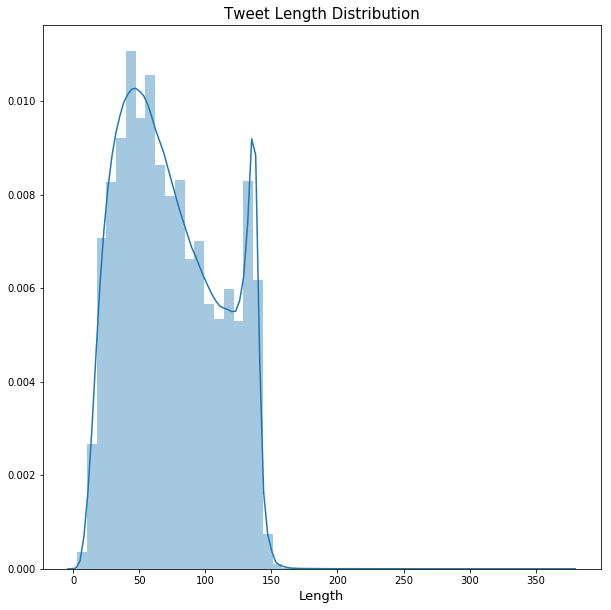

In [11]:
# distribution of tweets length
fig = plt.figure(figsize=(10,10))
sns.distplot(df.length)
plt.xlabel('Length',fontsize = 13)
plt.title('Tweet Length Distribution', fontsize = 15)
plt.show()

We can see 2 peaks in this distribution. The first one lies to 45-50 characters, and the second one to 130 characters. We can see that there are some tweets with more than 200 chars , or even more than 300! We can't definetely say that these are outliers, but we have to check. 


Create a dataframe with **min, mean & max** values for length of tweets before they got normalized!

In [12]:
length_grp = df[['sentiment','length']].groupby('sentiment').agg({'length': ['max', 'min','mean']})
length_grp

length               
             max min       mean
sentiment                      
0            347   3  74.878072
1            373   3  74.111183

Numbers are really close for both sentiments. Let's see below tweets with these characteristics!

In [13]:
print('- Text with positive sentiment and max characters:\n',df[df.sentiment == 1][df.length == 373],'\n')
print('- Text with positive sentiment and min characters:\n',df[df.sentiment == 1][df.length == 3],'\n')

print('- Text with negative sentiment and max characters:\n',df[df.sentiment == 0][df.length == 347],'\n')
print('- Text with negative sentiment and min characters:\n',df[df.sentiment == 0][df.length == 3])

- Text with positive sentiment and max characters:
         sentiment                                               text  length
111263          1  @catfish_ohm à¹€à¸„à¹‰à¸²à¹ƒà¸«à¹‰à¸?à¸²à¸£à¹Œ...     373 

- Text with positive sentiment and min characters:
          sentiment text  length
741962           1  hey       3
1220293          1  Yes       3 

- Text with negative sentiment and max characters:
         sentiment                                               text  length
717033          0  human shield à®Žà®©à¯?à®± à®šà¯Šà®±à¯?à®¤à¯Šà®...     347 

- Text with negative sentiment and min characters:
          sentiment text  length
1157988          0  Ugh       3


Tweets with maximum number of characters have some decoding issues

### Time for data cleaning

Below there is a graph of a **pipeline** that is used for text cleaning! Let me **explain** my thoughts on this, and **what every function does**. The raw text input is passing through:
- **strip text:** text striped of white spaces from left and right
- **remove html tags:** there are several html tags (like quotes, amp etc.) in the text. Have to remove them. Example "Stefanos said, he quot;lovesquot; noodles"
- **remove mentions @:** mentions start with "@" and include a name account! No use in sentiment!
- **replace suffix:** convert "don't" to "do not", "I'll" to "I will", "You've" to "You have" etc. Most of these words are gone as stop words. But if we don't "fix" them we may have an enormous Bag of words including occurences like dont and don or souldnt and shouldn etc. Additionaly there are some words to fix, one for suffix replacement ("yucky"), one for removal ("xxx") etc.
- **remove urls:** url links http://..., https://... and www. are useless.
- **remove hashtags #:** Twiiter is known for hashtags, and twitters use them for a trend topic, for searching other popular hashtags, or even to express an emotion! Pros: 1word, #happy -> happy / Cons: more than 1 words, #whenrainsitpours -> whenrainsitpours
- **replace repeated characters:** this one is a module named "expressions" and is used to detect and replace any expressions like *"aaaaahhhh"*, *"aaah"*, *"aaaww"*, *"aaaaa"*, *"zzzZZzz"* and *"hahahahaha"*. Each one is replaced with a standard word in order to have similarities in tweets. Also, "yuummyyy", "yuuuummm" and "yeeeahh" are replaced with "yum" and "yeah". One more time **we don't want noise in our Bag Of Words**!
- **replace emojis:** Basic emojis for "happy","sad" and "sarcastic" are replaced with words! This is a module under the name "emoticons".
- **lemmatization:** A popular technique to reduce the size of BOW.*"lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning."*
- **remove stop words:** Remove words that are more than frequent. sklearn's STOPWORDS are more than 300
- **remove slangs and acronyms:** This is a module to **re-define** some words. Slangs are oftenly used by young people and twitters use them to reduce the size of their text. By this time, more than 140 slangs and acronyms are collected manually! Slanger module was written a few months ago but got updated for this. Emoticons and expressions are modules that constructed for this task.
- **remove any character, number or symbol** is left in the corpus.
- **remove any left white spaces**( > 1)

<img src="pipeline.pdf"/>

In [14]:
# Import Libraries for text cleaning
import spacy
import en_core_web_sm as en
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
nlp = en.load()


I do like to use spaCy. It's prety speedy and accurate!

In [15]:
# FUNCTIONS FOR CLEANING

# REMOVE HTML TAGS
def remove_htmlTags(text):
    untagged = BeautifulSoup(text, 'lxml')
    return(untagged.get_text())

# REMOVE MENTIONS 
def remove_mentions(text):
    pattern = r'@[a-zA-Z0-9]+'
    return(re.sub(pattern, '', text))

# REMOVE URLS
def remove_urls(text):
    pattern = r'(https?://[a-zA-Z0-9./]+)|(www.[a-zA-Z0-9./]+)'
    return(re.sub(pattern, '', text))

# MODULE FOR REPEATED CHARACTERS
from expressions import expressions
# MODULE FOR EMOTICONS
from emoticons import emoticons

# LEMMATIZATION
def lemmas(text):
    text = nlp(text)
    text = [t.lemma_.lower().strip() if t.lemma_ != '-PRON-' else t.lower_ for t in text]
    return(text)

# REMOVE STOPWORDS
def stopWords(text):
    text = ' '.join([t for t in text if t not in set(list(ENGLISH_STOP_WORDS)+
                     list(punctuation) + [ "--", "---", "...", "“", "”"])])
    return(text)

# MODULE FOR SLANGS AND ACRONYMS
from slang import slanger, slang_map
# search every word separately

def slang_in_corpus(text):
    text = ' '.join([slanger(w) if w in list(slang_map.keys()) else w for w in text])
    return(text)

# REMOVE LEFT CHARS,NUMS,SYMBOLS
def leftChars(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    # remove single characters
    text = ' '.join([w for w in text.split() if len(w)>=2])
    return(text)


In [16]:
### PIPELINE    

#!CAUTION! if we want stop words turn stop_words and split off (False), else remove stop words with "True" boolean

def text_normalizer(text, strip_text = True, htmlTags = True, mentions = True, sub_suffix = True,
                    urls = True, hashtags = True, expression = True, emojis = True ,lemmatization = True,
                    stop_words = True, split = True,
                    slangs = True, leftos = True, white_spaces = True):
    
    if strip_text:
        text = text.strip()

    if htmlTags:
        text = remove_htmlTags(text)
    
    if mentions:
        text = remove_mentions(text)
        
    if sub_suffix:
        text = re.sub("n't", ' not', text)
        text = re.sub("'d", ' would', text)
        text = re.sub("'ll", ' will', text)
        text = re.sub("'m", ' am', text)
        text = re.sub("Im", 'I am', text)
        text = re.sub(" 've", ' have', text)
        text = re.sub("its", 'it is', text)
        text = re.sub("dont", 'do not', text)
        text = re.sub('yucky', 'yuck', text)
        text = re.sub('xxx', ' ', text)

    if urls:
        text = remove_urls(text)
    
    if hashtags:
        text = re.sub('#', '', text)
    
    # use functions in a specific order for better results        
    if expression:
        text = expressions(text)
    # replace emojis before any symbol is gone forever
    if emojis:
        text = emoticons(text)

    if lemmatization:
        text = lemmas(text)
        
    if stop_words:
        text = stopWords(text)
    
    if split:
        text = text.split()
        
    # replace slangs & acronyms 
    if slangs:
        text = slang_in_corpus(text)
        
    if leftos:
        text = leftChars(text)
    
    if white_spaces:
        text = re.sub(' +', ' ', text)
    
    return(text.strip())


#### Something to note...

At this point 1.42M observations are too many for my computational power and my laptop. So, please allow me to take a **random sample** of ~280,000 examples and work with them. Analysis, Zipf's Law and classifier will be based on this sample!

In [ ]:
# TAKE A RANDOM SAMPLE OF ~280K
# sample 1
sample_df = df.sample(frac=0.20, replace=True)

I had a problem because a kernel died and I lost some observations. Although, I continue with the rest of them!

In [17]:
sample_df = pd.read_csv('train_sample.csv')
sample_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'clean_text', 'clean_text_nsw', 'length',
       'sentiment', 'text'],
      dtype='object')

In [18]:
sample_df = sample_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

In [19]:
# ratio of labels
sample_df.sentiment.value_counts()

1    76513
0    72241
Name: sentiment, dtype: int64

In [ ]:
# get tokens included stop words (for Zipf's law)
# in def text_normalizer: stop_words = False, split = False

sample_df['clean_text']= sample_df['text'].apply(lambda x: text_normalizer(x))

In [ ]:
# get tokens but stop words are removed
# in def text_normalizer: stop_words = True, split = True

sample_df['clean_text_nsw'] = sample_df['text'].apply(lambda x: text_normalizer(x))

In [20]:
# So after text cleaning we got
sample_df[:10]

,clean_text,clean_text_nsw,length,sentiment,text
0,be so sad for my apl friend,sad apl friend,61,0,is so sad for my APL frie...
1,miss the new moon trailer,miss new moon trailer,51,0,I missed the New Moon trail...
2,oh my god it be already,oh my god,37,1,omg its already 7:30 :O
3,omgaga be sooo be going to cry have be at this...,omgaga sooo going to dentist supos just crown min,132,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,or just worry too much,just worry,34,0,or i just worry too much?
5,juuuuuuuuuuuuuuuuussssst chillin,juuuuuuuuuuuuuuuuussssst chillin,41,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
6,sunny again work tomorrow sad tv tonight,sunny work tomorrow sad tv tonight,61,0,Sunny Again Work Tomorrow :-| ...
7,hand in my uniform today miss you already,hand uniform today miss,53,1,handed in my uniform today . i miss you ...
8,hmmmm wonder how she my number,hmmmm wonder number,46,1,hmmmm.... i wonder how she my number @-)
9,must think about positive,think positive,35,0,I must think about positive..


### sample_df  analysis...continues

In [21]:
# length of clean text
sample_df['clean_length'] = sample_df['clean_text'].apply(lambda x: len(x))

In [22]:
# length of clean text, no stop words
sample_df['clean_length_nsw'] = sample_df['clean_text_nsw'].apply(lambda x: len(x))

In [23]:
sample_df[:2]

,clean_text,clean_text_nsw,length,sentiment,text,clean_length,clean_length_nsw
0,be so sad for my apl friend,sad apl friend,61,0,is so sad for my APL frie...,27,14
1,miss the new moon trailer,miss new moon trailer,51,0,I missed the New Moon trail...,25,21


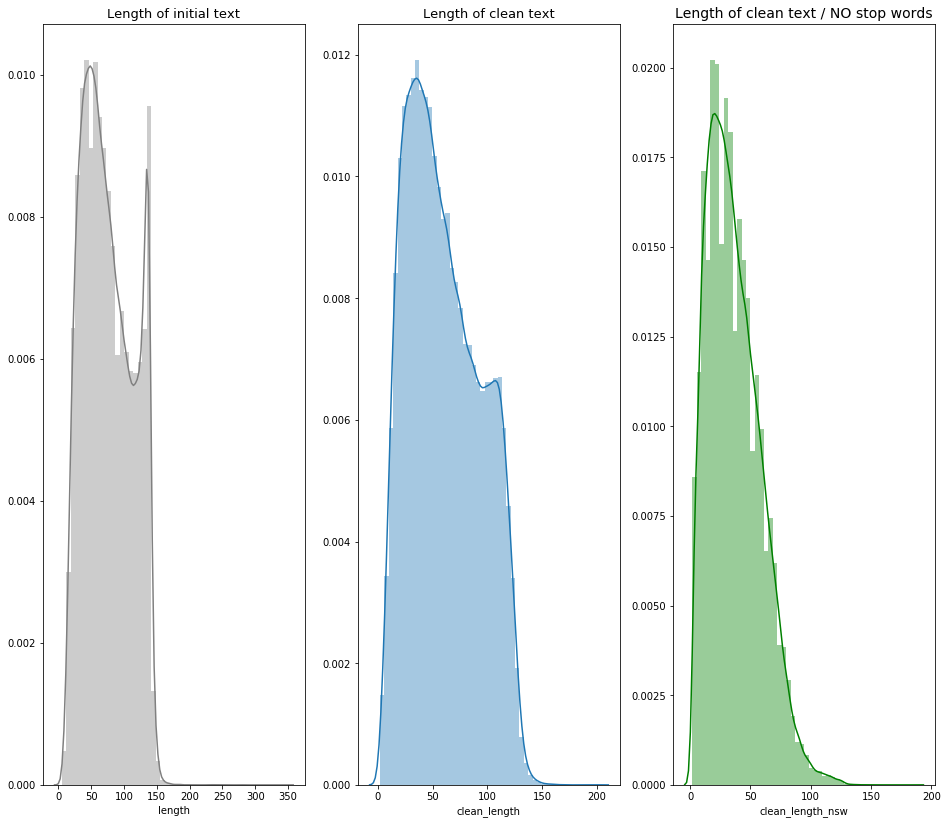

In [24]:
fig, ax = plt.subplots(figsize=(16,14))
plt.subplot(1,3,1)
sns.distplot(sample_df.length, color = 'gray')
plt.title('Length of initial text', fontsize = 13)
plt.subplot(1,3,2)
sns.distplot(sample_df.clean_length)
plt.title('Length of clean text', fontsize = 13)
plt.subplot(1,3,3)
sns.distplot(sample_df.clean_length_nsw, color = 'green')
plt.title('Length of clean text / NO stop words', fontsize = 14)
plt.show()


After removing some hashtags, urls, mentions, characters etc. clean_length's distribution right peak seems to get expunged. Third distribution has no stopwords, only some of them in slangs and acronyms. The last distribution (green) seems like a right skewed normal distribution.

In [25]:
# green distribution
sample_df.clean_length_nsw.skew()

0.7335483022879566

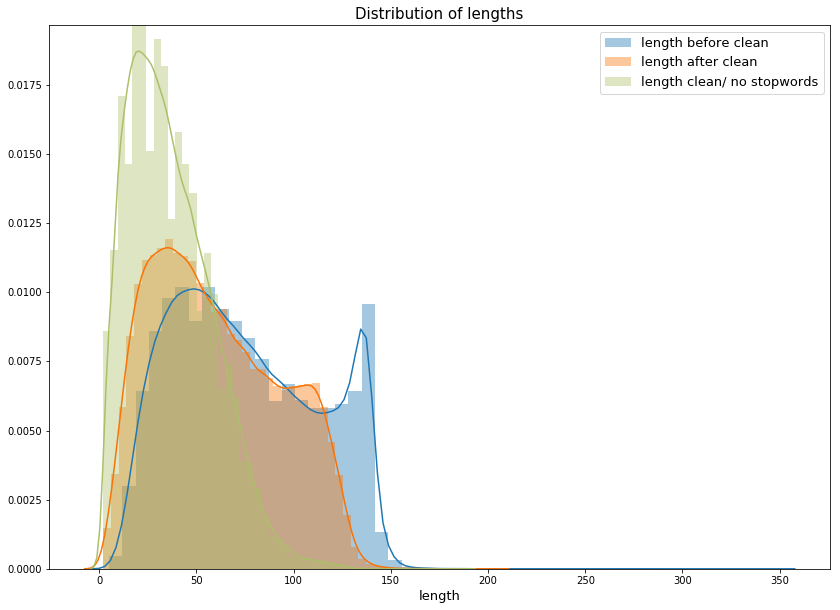

In [26]:
# 3 Plots in 1
fig = plt.figure(figsize=(14,10))
sns.distplot(sample_df.length)
sns.distplot(sample_df.clean_length, color = '#f97306')
sns.distplot(sample_df.clean_length_nsw, color = '#acbf69')
plt.legend(['length before clean', 'length after clean', 'length clean/ no stopwords'], fontsize = 13)
plt.xlabel('length', fontsize = 13)
plt.title('Distribution of lengths', fontsize = 15)
plt.show()

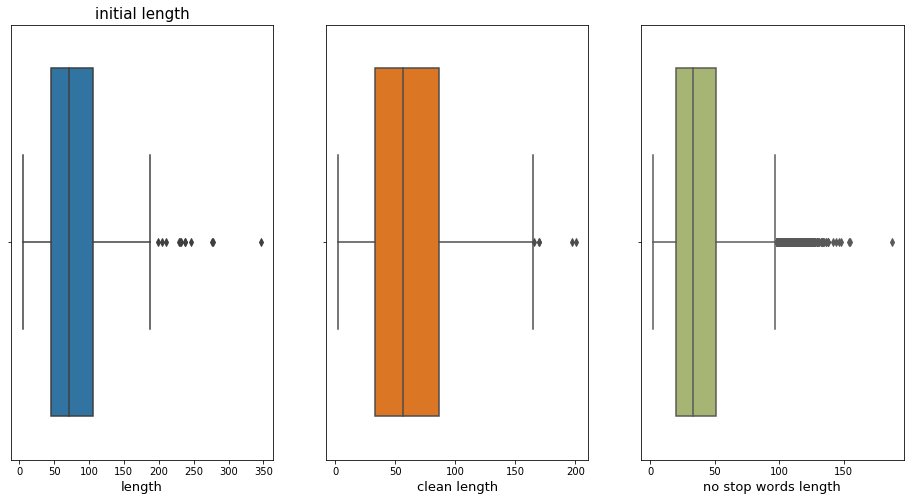

In [27]:
# Some boxplots
fig = plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
sns.boxplot(sample_df.length)
plt.xlabel('length', fontsize = 13)
plt.title('initial length', fontsize = 15)

plt.subplot(1,3,2)
sns.boxplot(sample_df.clean_length, color = '#f97306')
plt.xlabel('clean length', fontsize = 13)
plt.title('', fontsize = 15)

plt.subplot(1,3,3)
sns.boxplot(sample_df.clean_length_nsw, color = '#acbf69')
plt.xlabel('no stop words length', fontsize = 13)
plt.title('', fontsize = 15)
plt.show()

It is interesting in 3rd boxplot that there are a lot of tweets with length bigger than the upper limit of 3rd quartile ( Q3+1.5*IQR).

#### How many words removed after cleaning?



In [28]:
length_diff = sample_df[['length','clean_length','clean_length_nsw']]

In [29]:
length_diff['clean_length_diff'] = length_diff.length - length_diff.clean_length
length_diff['clean_length_nsw_diff'] = length_diff.length - length_diff.clean_length_nsw

In [30]:
length_diff[:5]

,length,clean_length,clean_length_nsw,clean_length_diff,clean_length_nsw_diff
0,61,27,14,34,47
1,51,25,21,26,30
2,37,23,9,14,28
3,132,95,49,37,83
4,34,22,10,12,24


Time for a controversial plot.... Wordcloud!

It is believed that a wordcloud barely gives information. But to be honest, I use wordclouds because I have quick (and useful) insights of the corpus!

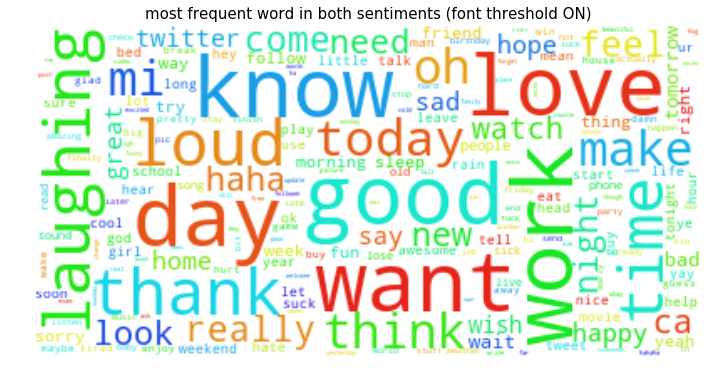

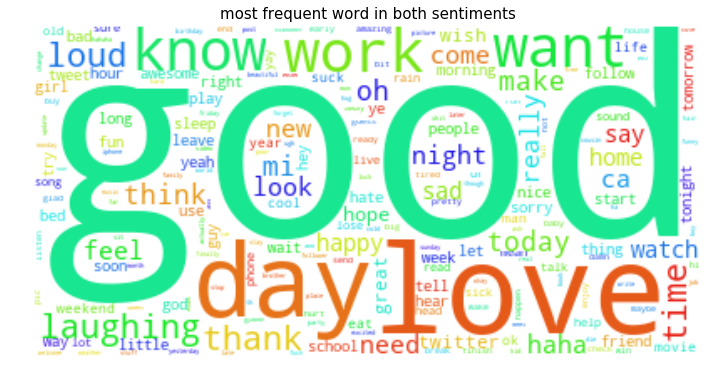

In [31]:
# WORDCLOUDS (no stop words)
from wordcloud import WordCloud

corpus = list(sample_df['clean_text_nsw'])
corpus = ' '.join(corpus)

# fontsize threshold
wordcloud = WordCloud(background_color="white", max_font_size = 50).generate(corpus)
plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("most frequent word in both sentiments (font threshold ON)", fontsize = 15)
plt.axis("off")
plt.show()

wordcloud = WordCloud(background_color="white").generate(corpus)
plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("most frequent word in both sentiments", fontsize = 15)
plt.axis("off")
plt.show()


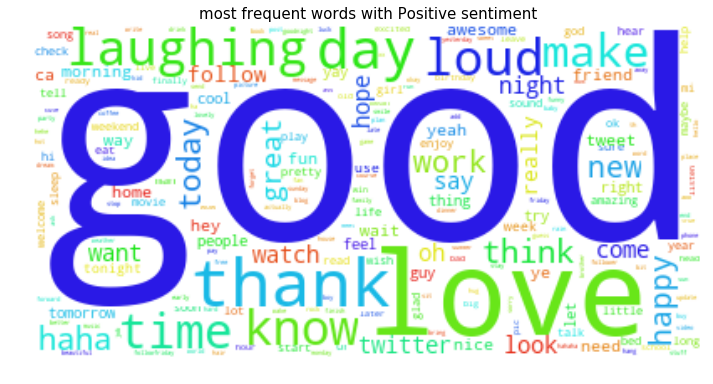

In [32]:
# Positive Wordcloud
pos = sample_df.loc[sample_df.sentiment == 1]['clean_text_nsw']
pos =  list(pos)
pos_corpus = ' '.join(pos)

wordcloud = WordCloud(background_color="white").generate(pos_corpus)
plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("most frequent words with Positive sentiment", fontsize = 15)
plt.axis("off")
plt.show()


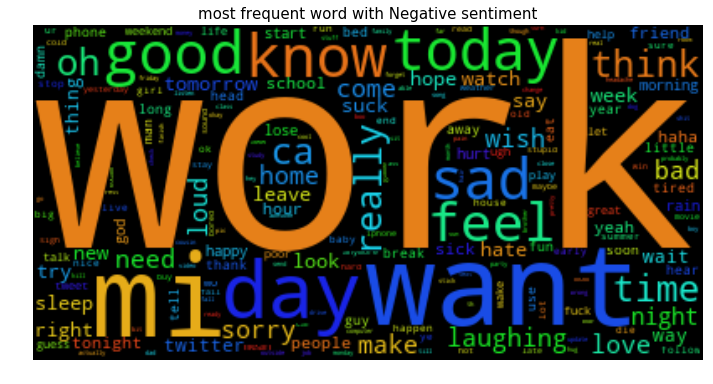

In [33]:
# Negative Wordcloud
neg = sample_df.loc[sample_df.sentiment == 0]['clean_text_nsw']
neg =  list(neg)
neg_corpus = ' '.join(neg)

wordcloud = WordCloud().generate(neg_corpus)
plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("most frequent word with Negative sentiment", fontsize = 15)
plt.axis("off")
plt.show()


In [34]:
# WHY "good" is in Negative sentiment wordcloud
i = 0
for words in sample_df.loc[sample_df.sentiment == 0]['text']:
    if 'good' in words and i<=5:
        i += 1
        print(words)
        print("--"*30)

" #Susan Boyle didnt win! mh well, diversity was very good though! CONGRATZ!!"
------------------------------------------------------------
 .bueno good bye. good night
------------------------------------------------------------
   Wondering why I feel like I do...I'll feel better though...Its all good! I'll be happy inspite of...Tweet ya lata
------------------------------------------------------------
 @TheIanCrawford is no longer in the Cab. To say I'm heartbroken is an understatement... good luck with everything! you're amazing ian.
------------------------------------------------------------
" Airport Express doesn't rock enough to allow wireless scanning with the Canon pixma MX310, but otherwise it's wireless goodness."
------------------------------------------------------------
  goodnight..
------------------------------------------------------------


In [35]:
# happy in negative sentiment
i=0
for words in df[df.sentiment == 0]['text']:
    if 'happy' in words and i<=5:
        i += 1
        print("--"*30)
        print(words)

------------------------------------------------------------
    I just cut my beard off. It's only been growing for well over a year. I'm gonna start it over. @shaunamanu is happy in the meantime.
------------------------------------------------------------
   Wondering why I feel like I do...I'll feel better though...Its all good! I'll be happy inspite of...Tweet ya lata
------------------------------------------------------------
  To all the mothers whose day may not be so happy. God loves you. TLC - Waterfalls ? http://blip.fm/~5zi9g
------------------------------------------------------------
 @lazoug KStew and MA still together http://bit.ly/cdrcw happy or not?? Lol Im happy if Kristen is happy
------------------------------------------------------------
 happy hour ended! Bummer in the summer. I guess I have to ride my bike back to carson.
------------------------------------------------------------
 i dont fell happy right now


In [36]:
# sad in positive sentiment
i=0
for words in df[df.sentiment == 1]['text']:
    if 'sad' in words and i<=5:
        i += 1
        print("--"*30)
        print(words)

------------------------------------------------------------
-- that my head doesn't think so. *chuckle*  G'Night!  *waves* ... *to no one at all*  huh.  sad.  just sad.  *chuckle*
------------------------------------------------------------
 nothing like some physics humor and big bang theory to put a smile on a sad face
------------------------------------------------------------
"&quot;Hey  Jude, don't make it bad, just take a sad song and make it better.&quot;  "
------------------------------------------------------------
&quot;Our sweetest songs are those that tell of the saddest thought&quot; To A Skylark- Percy Bysshe Shelley. Reminds me of Taylor Swift
------------------------------------------------------------
#FollowFriday thx @crusaderz4life -- and thanks for makin me laugh and smile today!
------------------------------------------------------------
"#myweakness Music, writing lyrics even if they always seem to be about sadness &amp; nothing more. my #2 Motley Crue "


It's hard to define the sentiment with only one word. We need context-words to understand the sentiment.

### TASK 2: Top 10 Positive / Negative words

Let's count them...

In [37]:
# Count TOP 10 Positive/Negative words (no stop words)

# Get names and counts with Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# call object
cv = CountVectorizer()
cv.fit(sample_df['clean_text_nsw'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [40]:
# This function counts word's occurrences for each sentiment
import numpy as np
def count_sentiment_words(vect, column):

    # create matrices
    neg_matrix = vect.transform(sample_df[sample_df.sentiment == 0][column])
    pos_matrix = vect.transform(sample_df[sample_df.sentiment == 1][column])

    # sum up the occurences for every word
    neg_tf = np.sum(neg_matrix,axis=0)
    pos_tf = np.sum(pos_matrix,axis=0)

    negative = np.squeeze(np.asarray(neg_tf))
    positive = np.squeeze(np.asarray(pos_tf))
    
    return(pd.DataFrame([negative, positive], columns=vect.get_feature_names()).transpose())

In [41]:
# create a dataframe with counts
frequency_df = count_sentiment_words(cv, 'clean_text_nsw')

In [42]:
frequency_df[:3]

,0,1
ab,10,11
aba,2,2
aback,0,1


In [45]:
# Top 10 Negative
frequency_df[0].sort_values(ascending = False)[:10]

just     5702
work     4876
want     4664
miss     4316
day      4185
like     4084
good     3810
know     3288
you      3267
today    3267
Name: 0, dtype: int64

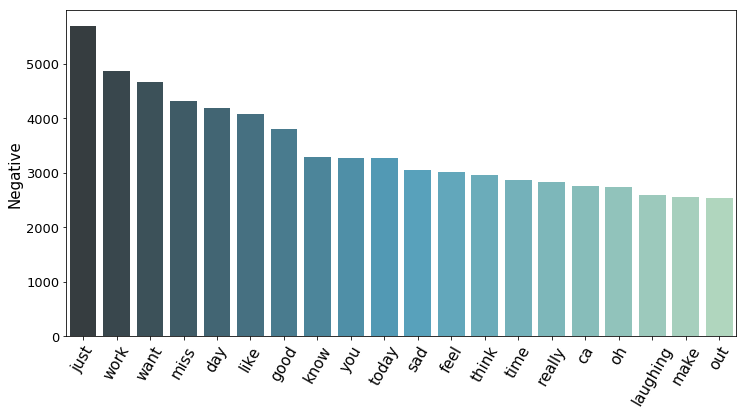

In [43]:
fig = plt.figure(figsize=(12,6))
sns.barplot(frequency_df[0].sort_values(ascending = False)[:20].index,
            frequency_df[0].sort_values(ascending = False)[:20],
            palette = "GnBu_d")
plt.xticks(rotation = 60, fontsize =15)
plt.yticks(fontsize =13)
plt.ylabel('Negative', fontsize = 15)
plt.show()

In [44]:
# Top 10 Positive
frequency_df[1].sort_values(ascending = False)[:10]

good        7827
love        6550
just        5826
thank       5477
you         4832
day         4706
like        4085
laughing    3938
out         3816
loud        3735
Name: 1, dtype: int64

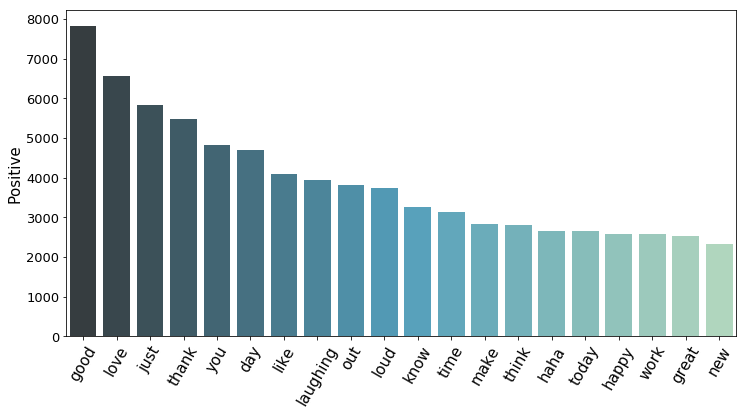

In [46]:
fig = plt.figure(figsize=(12,6))
sns.barplot(frequency_df[1].sort_values(ascending = False)[:20].index,
            frequency_df[1].sort_values(ascending = False)[:20],
            palette = "GnBu_d")
plt.xticks(rotation = 60, fontsize =15)
plt.yticks(fontsize =13)
plt.ylabel('Positive', fontsize = 15)
plt.show()

There are some common words in both sentiments. 

------------------------------------------------------------
"Extra analysis of corpus"

I'm checking out the most common words that exist in both "sentiments".

In [47]:
### MOST COMMON WORDS BOTH IN POS/NEG
commons = pd.DataFrame(columns = ['word', 'count_pos', 'count_neg'])

for i in frequency_df[1].sort_values(ascending = False)[:20].index:
    if i in frequency_df[0].sort_values(ascending = False)[:20].index:
        commons.loc[i] = i, frequency_df[1].sort_values(ascending = False)[:20][i],frequency_df[0].sort_values(ascending = False)[:20][i]

commons = commons.reset_index(drop = True)


In [48]:
print("size of 'commons':",commons.shape)
commons

size of 'commons': (13, 3)


,word,count_pos,count_neg
0,good,7827,3810
1,just,5826,5702
2,you,4832,3267
3,day,4706,4185
4,like,4085,4084
5,laughing,3938,2587
6,out,3816,2544
7,know,3268,3288
8,time,3138,2874
9,make,2833,2551


#### Note: 
If words like "just", "know", "like" are in a sentiment is hard to find based only in 1 word what is the correct label

<Figure size 1080x576 with 0 Axes>

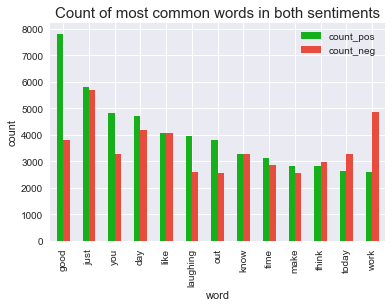

In [49]:
plt.figure(figsize=(15,8))
pal = ['#15b01a', '#e74c3c']
sns.set()
commons.set_index('word').plot(kind='bar',stacked=False, colors = pal)
plt.ylabel('count')
plt.title('Count of most common words in both sentiments', fontsize = 15)
plt.show()

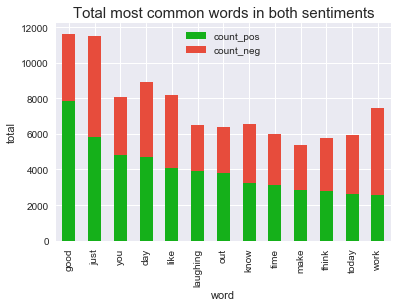

In [50]:
commons.set_index('word').plot(kind='bar',stacked=True, colors = pal)
plt.ylabel('total')
plt.title('Total most common words in both sentiments', fontsize = 15)
plt.legend(loc = 9)
plt.show()

### Task3: Zipf's law


I need stop words in this task. So, I'm gonna use the "clean_text" column. I need stop words because Zipf's law is based on them. 

In [51]:
cvz = CountVectorizer()
cvz.fit(sample_df['clean_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [52]:
# Create dataframe with stop words
zipf_df = count_sentiment_words(cvz, 'clean_text')

In [53]:
# Create "total" column to the sum of counts of each word
zipf_df['total'] = zipf_df[0]+zipf_df[1]

In [54]:
zipf_df.shape

(57666, 3)

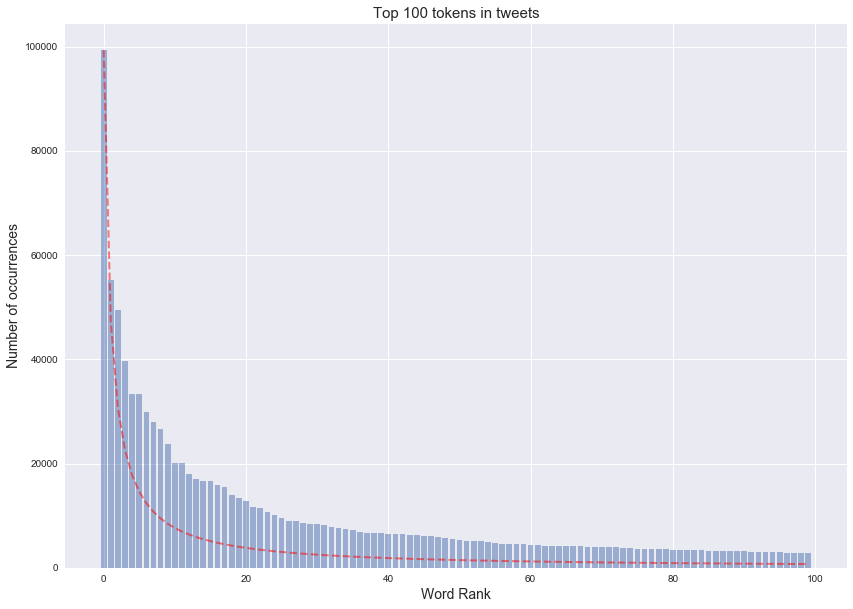

In [56]:
# select the first 500 words to examine "Zipf's law" case

# step for ranking words
y_pos = np.arange(100)
# the exponent of denominator
s = 1.07

plt.figure(figsize=(14,10))
# draw a line with expected results
expected_zipf = [zipf_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
# zipf's "distribution"
plt.bar(y_pos, zipf_df.sort_values(by='total', ascending=False)['total'][:100], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.xlabel('Word Rank', fontsize = 14)
plt.ylabel('Number of occurrences', fontsize = 14)
plt.title('Top 100 tokens in tweets', fontsize = 15)
plt.show()

In [57]:
# What we expected for and we what we finaly got
for i in range(5):
    print(zipf_df.sort_values(by='total', ascending=False)['total'].index[i],': we got',
          zipf_df.sort_values(by='total', ascending=False)['total'][i],', we expected',
          round(expected_zipf[i]))

be : we got 99341 , we expected 99341.0
to : we got 55258 , we expected 47318.0
the : we got 49464 , we expected 30663.0
you : we got 39590 , we expected 22538.0
not : we got 33435 , we expected 17751.0


#### Conclusion

The expectation is not verified! Although, our result tends to follow a distribution that seems like Zipf's distribution! Maybe the result could be more accurate, if we got more rows of examples from the initial dataframe. Thus we could have more words like "the", "of", "and", "to", "in", "for" and the list goes on...

### TASK 4  Classifier

Time for the predictive model.

**Step1:** train/test split data. Train set is 80% of data and test set is the rest 20%.

**Step2:** Build Bag Of Words (BOW) using sklearn's Count Vectorizer (CV). CV transform text documents to a matrix of words(tokens) count. Hence, our vocabulary has the size of the number of unique words. 

Use TF-IDF vectorizer to normalize term frequencies and compare results.

**Step3:** Check different ngram range to fit data as good as we can.

**Step4:** Use Naive Bayes algorithm to predict sentiment.

**Step5:** Using metrics to evaluate results.

Notes: 

Using BOW has some cons. In BOW every word is independent. This means that BOW does not catch the sentiment, the part of speech or any other contextual meaning. Hence, the size of the vocabulary is getting bigger as the number of documents increasing. This means that we'll have a sparse matrix with a lot of "0"'s. 2013 was the beginning to overcome this difficulty, with word2vec model coming in the surface!

Using a trigram instead of using a unigram is more likely to catch the sentiment. We'll see.

Why Naive Bayes? Is a supervised probabilistic learning method. "Naive" comes from the assumption that the features are independent. Thus, considering the BOW consists of independent attributes, I do prefer Naive Bayes. It's fast, robust and accurate for NLP tasks.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [59]:
from sklearn.model_selection import train_test_split

# shuffle rows
sample_train = sample_df.sample(frac=1).reset_index(drop=True)

#### Case 1: Train with no stop words

In [60]:
# select features and target value
X = sample_train.clean_text_nsw.values
y = sample_train.sentiment.values

In [61]:
# train-test split 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [62]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((119003,), (119003,), (29751,), (29751,))

In [63]:
# balance of labels 
from collections import Counter
print(Counter(y_train), Counter(y_test))

Counter({1: 61173, 0: 57830}) Counter({1: 15340, 0: 14411})


#### Count Vectorizer (CV)

In [64]:
# initialize Vectorizer
CV = CountVectorizer()

In [65]:
# Naive Bayes Classifier
nb = MultinomialNB()

In [66]:
def Model(cvect, ngram, clf, x_tr, x_tst, y_tr, y_tst):
    
    cvect.set_params(ngram_range = ngram)
    
    pipe = Pipeline([('vectorizer', cvect),
                     ('classifier', clf)])
    
    pipe.fit(x_tr, y_tr)
    
    y_pred = pipe.predict(x_tst) 
    
    #print('Pipeline parameters:', pipe.get_params,'\n\n')
    print('Get some feature names:',pipe.named_steps['vectorizer'].get_feature_names()[:10],'\n\n')
    print('Vocabulary size:',len(sample_train),'x',len(pipe.named_steps['vectorizer'].get_feature_names()),'\n')
    
    acc = accuracy_score(y_tst, y_pred)
    f1 = f1_score(y_tst, y_pred)
    conf_m = confusion_matrix(y_tst, y_pred)
    report = classification_report(y_tst, y_pred)
    
    return(acc, f1, conf_m, report)

#### TF-IDF

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer()

I will fit count vectorizer and tf-idf vectorizer to train set, using trigrams and compare the results. Like I said somewhere above, it is more likely to catch the sentiment if we use trigram instead of unigram.

In [69]:
# Examine how vectorizers and NB perform
for vec in [CV, tfidf]:
    acc, f1, conf_m, report = Model(vec, (1,3), nb, x_train, x_test, y_train, y_test)
    print('Confusion matrix with '+str(vec)[:15],'\n',conf_m,'\n')
    print('acc',acc)
    print('f1',f1,'\n')
    print(report)
    print()
    

Get some feature names: ['ab', 'ab bri', 'ab bri chan', 'ab decorate', 'ab decorate apt', 'ab despite', 'ab despite promise', 'ab diet', 'ab diet tweet', 'ab good'] 


Vocabulary size: 148754 x 928323 

Confusion matrix with CountVectorizer 
 [[10635  3776]
 [ 3523 11817]] 

acc 0.754663708782898
f1 0.764038405586267 

             precision    recall  f1-score   support

          0       0.75      0.74      0.74     14411
          1       0.76      0.77      0.76     15340

avg / total       0.75      0.75      0.75     29751


Get some feature names: ['ab', 'ab bri', 'ab bri chan', 'ab decorate', 'ab decorate apt', 'ab despite', 'ab despite promise', 'ab diet', 'ab diet tweet', 'ab good'] 


Vocabulary size: 148754 x 928323 

Confusion matrix with TfidfVectorizer 
 [[10281  4130]
 [ 3084 12256]] 

acc 0.7575207556048537
f1 0.7726155203933682 

             precision    recall  f1-score   support

          0       0.77      0.71      0.74     14411
          1       0.75      0.80 

Vocabulary dimension is 148754 x 928323 which is prety big for 150K rows of data. Here we see that tf-idf method performs better. 

#### Case 2: Train with stop words (initialize the process)

In [70]:
# select features and target value
X2 = sample_train.clean_text.values
y2 = sample_train.sentiment.values

In [71]:
# train-test split 
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 100)

In [72]:
CV2 = CountVectorizer()
tfidf2 = TfidfVectorizer()
nb2 = MultinomialNB()

In [73]:
# Examine how vectorizers and NB perform
for vec in [CV2, tfidf2]:
    acc, f1, conf_m, report = Model(vec, (1,3), nb2, x_train2, x_test2, y_train2, y_test2)
    print('Confusion matrix with '+str(vec)[:15],'\n',conf_m,'\n')
    print('acc',acc)
    print('f1',f1,'\n')
    print(report)
    print()

Get some feature names: ['ab', 'ab be', 'ab be on', 'ab be the', 'ab bri', 'ab bri chan', 'ab decorate', 'ab decorate my', 'ab despite', 'ab despite promise'] 


Vocabulary size: 148754 x 1285739 

Confusion matrix with CountVectorizer 
 [[11797  2614]
 [ 3757 11583]] 

acc 0.7858559376155423
f1 0.784304431729695 

             precision    recall  f1-score   support

          0       0.76      0.82      0.79     14411
          1       0.82      0.76      0.78     15340

avg / total       0.79      0.79      0.79     29751


Get some feature names: ['ab', 'ab be', 'ab be on', 'ab be the', 'ab bri', 'ab bri chan', 'ab decorate', 'ab decorate my', 'ab despite', 'ab despite promise'] 


Vocabulary size: 148754 x 1285739 

Confusion matrix with TfidfVectorizer 
 [[11569  2842]
 [ 3285 12055]] 

acc 0.7940573426103325
f1 0.7973674637034097 

             precision    recall  f1-score   support

          0       0.78      0.80      0.79     14411
          1       0.81      0.79      0.80

Model with Tf-Idf vectorizer, ngram range (1,3), and use of stop words performs really good. I do chose to evaluate training with f1 score and get more precise results than accuracy score. Next step is to validate the model with unseen data and address the probability of over/under-fitting.

To get a proper estimate of the generalization we have to compute the score on another test set.

In [74]:
test = pd.read_csv('test.csv')

In [75]:
test.shape

(157863, 4)

In [ ]:
#test_sample = test_sample.drop('Unnamed: 0', axis = 1)

1.5M lines are too many for my laptop.

In [ ]:
# take a random sample again
test_sample = test.sample(frac=0.01, replace=True)

I'm passing test data through the same pipeline and transform it with tfidf2.

In [ ]:
test_sample['clean_text'] = test_sample['text'].apply(lambda x: text_normalizer(x))

In [ ]:
test_sample['clean_text'] = test_sample['text'].apply(lambda x: text_normalizer(x))

In [ ]:
#test_sample.to_csv('test_sample.csv', encoding = 'utf-8')

In [76]:
test_sample = pd.read_csv('test_sample.csv')

In [77]:
test_sample = test_sample.dropna()

In [78]:
test_sample.shape

(10966, 7)

As I did chose to keep the model with stop words, I'm going to transform clean text with stop words from test set!

In [79]:
test_matrix = tfidf2.transform(test_sample.clean_text)

In [80]:
test_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
test_pred = nb2.predict(test_matrix)

In [83]:
print('The score on test set is: ',f1_score(test_sample.sentiment, test_pred))

The score on test set is:  0.7838338895068595


#### Conclusions

f1 score on train(validation) set is 0.797 (79.7%) and on the train set is 0.784 (78.4%). This means that the model generalizes well on test set and do not memorizes the examples.

One way to improve the performance is to add more data. Maybe we would have different results with 1.4M tweets. But we must be carefull not to overfit the model. To avoid overfitting we should use Kfold cross validation or Stratified Kfold cross validation (which is better for imbalanced classes). The bias-variance tradeoff is the key for good results. I tried to use 10 fold cross validation, but my laptop did have another opinion, so the kernel died several times. In this task we could use some different parameters in vectorizer such as min df or max df to cut very frequent or rarely frequent words and reduce the size of vocabulary. Evenmore, we could use a custom stop word list. As we saw above we got words that have equal occurrences in both sentiments.

#### A different approach / Using a Lexicon

Some extra stuff to compare methods!

I'm using Afinn Lexicon to extract the sentiment based on words with a polarity score! At the end I will compare the results of the lexicon approach with the actual ones!

In [84]:
lexicon_corpus = list(sample_df['clean_text'])

In [85]:
from afinn import Afinn
af = Afinn()

In [86]:
# score from every tweet/ positive >0, negative <0 
scores = [af.score(str(tweet)) for tweet in corpus]

In [88]:
# give a tag for every tweet
sentiment_id = [1 if score >0 else 0 for score in scores]

In [85]:
print('ok')

ok


In [ ]:
# create dataframe to see results
sentiment_df = pd.DataFrame([lexicon_corpus, scores, sentiment_id]).T #kernel died 

In [ ]:
sentiment_df.columns = ['text', 'score', 'sentiment']
sentiment_df['sentiment'] = sentiment_df.sentiment.apply(lambda x: numpy.int64(x))

In [88]:
# get dataframe drom anaconda spyder
# sentiment_df = pd.read_csv('twitter_sentiments.csv')
# sentiment_df = sentiment_df.drop('Unnamed: 0', axis = 1)

In [89]:
sentiment_df.head()

,text,score,sentiment
0,be so sad for my apl friend,-1.0,0
1,miss the new moon trailer,-2.0,0
2,oh my god it be already,1.0,1
3,omgaga be sooo be going to cry have be at this...,-1.0,0
4,or just worry too much,-3.0,0


In [93]:
print('accuracy of lexicon: ', accuracy_score(sample_df.sentiment, sentiment_df.sentiment))

accuracy of lexicon:  0.6381206555790097


Accuracy is lower than the supervised learning method -15%.

#### Thank you for your time and consideration!